<div style="height:100px">

<div style="display:inline-block; width:77%; vertical-align:middle;">
    <div>
        <b>Author</b>: <a href="http://pages.di.unipi.it/castellana/">Daniele Castellana</a>
    </div>
    <div>
        PhD student at the Univeristy of Pisa and member of the Computational Intelligence & Machine Learning Group (<a href="http://www.di.unipi.it/groups/ciml/">CIML</a>)
    </div>
    <div>
        <b>Mail</b>: <a href="mailto:daniele.castellana@di.unipi.it">daniele.castellana@di.unipi.it</a>
    </div>
</div>

<div style="display:inline-block; width: 10%; vertical-align:middle;">
    <img align="right" width="100%" src="https://upload.wikimedia.org/wikipedia/it/7/72/Stemma_unipi.png">
</div>

<div style="display:inline-block; width: 10%; vertical-align:middle;">
    <img align="right" width="100%" src="http://www.di.unipi.it/groups/ciml/Home_files/loghi/logo_ciml-restyling2018.svg">
</div>
</div>

# NN for Sequential Data 2

In this example we use the LSTM model for the same task of the previous example.

The only difference is that we cast the prediction task as a **many2many** problem.

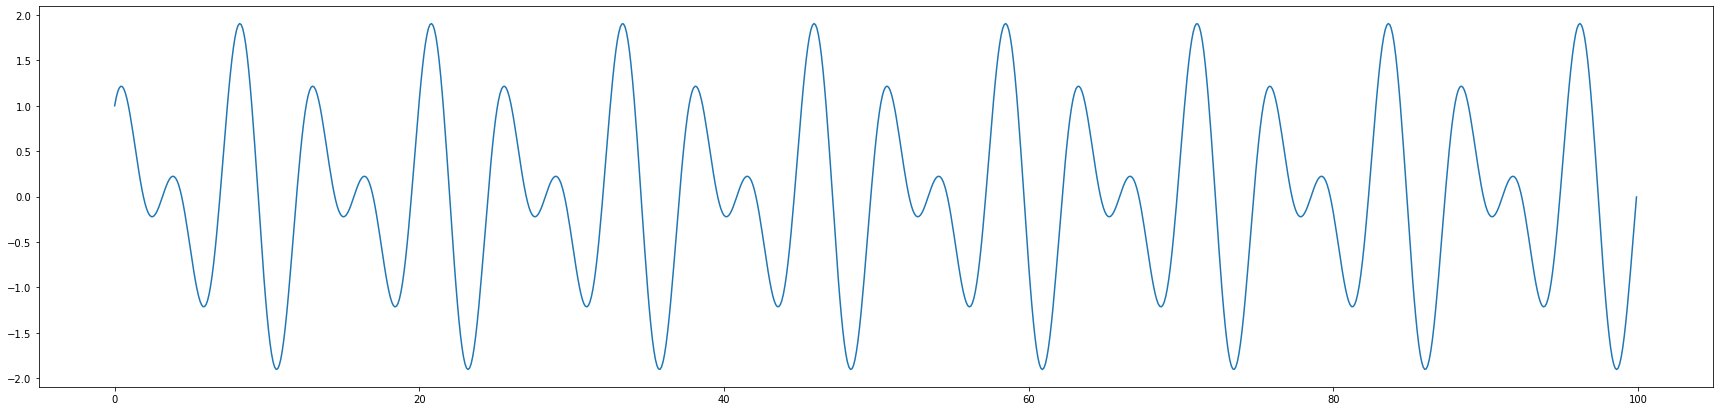

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x):
    return np.sin(x)+np.cos(3*x/2)

x=np.arange(0, 5000, 0.1)
plt.figure(figsize=(30, 7))
plt.plot(x[:1000], f(x[:1000]))
data = f(x)

## Define the model

Again, the LSTM layer requires a $N \times L \times D$ tensor as input.

The only difference between the model definition in the previous example is the use of the **TimeDistributed** layer.

The goal of TimeDistributed is to repeat a layer for each time-step in the sequence. In our case, we replicate the Dense layer which perform the prediction.

Also, we shoudl set the parameters **return_sequence=True** in the LSMT definition in order to to obtain a sequence as output.

In [2]:
from keras.layers import LSTM, Dense, TimeDistributed
from keras.models import Sequential

def build_LSTM_many2many():
    
    model = Sequential()
    model.add(LSTM(30, input_shape=(seq_len,1), return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

Using TensorFlow backend.


Again, we need to split the whole sequence to avoid gradient issue (see slides). However, now the small sequences are not overlapped.

In [3]:
#prepare data
def prepare_LSTM_many2many_data():
    x_train = np.array([data[i:i+seq_len] for i in range(0, len(data)-seq_len-1, seq_len)]).reshape(-1, seq_len, 1)
    y_train = np.array([data[i+1:i+seq_len+1] for i in range(0, len(data)-seq_len-1, seq_len)]).reshape(-1, seq_len, 1)
    
    return x_train, y_train

In [4]:
seq_len=40
x_train, y_train = prepare_LSTM_many2many_data()
print('The input shape is {}\n'
      'The output shape is {}'.format(x_train.shape, y_train.shape))

The input shape is (1249, 40, 1)
The output shape is (1249, 40, 1)


## Fit the model

In [5]:
LSTM_many2many = build_LSTM_many2many()

LSTM_many2many.fit(x_train, y_train, epochs=20, batch_size=100);

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1249/1249 [==============================] - 2s 2ms/step - loss: 0.8376
Epoch 2/20
1249/1249 [==============================] - 1s 442us/step - loss: 0.5593
Epoch 3/20
1249/1249 [==============================] - 1s 407us/step - loss: 0.3840
Epoch 4/20
1249/1249 [==============================] - 1s 411us/step - loss: 0.2572
Epoch 5/20
1249/1249 [==============================] - 1s 419us/step - loss: 0.1536
Epoch 6/20
1249/1249 [==============================] - 1s 478us/step - loss: 0.0945
Epoch 7/20
1249/1249 [==============================] - 1s 402us/step - loss: 0.0783
Epoch 8/20
1249/1249 [==============================] - 0s 389us/step - loss: 0.0694
Epoch 9/20
1249/1249 [==============================] - 0s 394us/step - loss: 0.0631
Epoch 10/20
1249/1249 [==============================] - 0s 390us/step - loss: 0.0576
Epoch 11/20
1249/1249 [========

## Next-step prediction

In [6]:
pred = LSTM_many2many.predict(x_train)

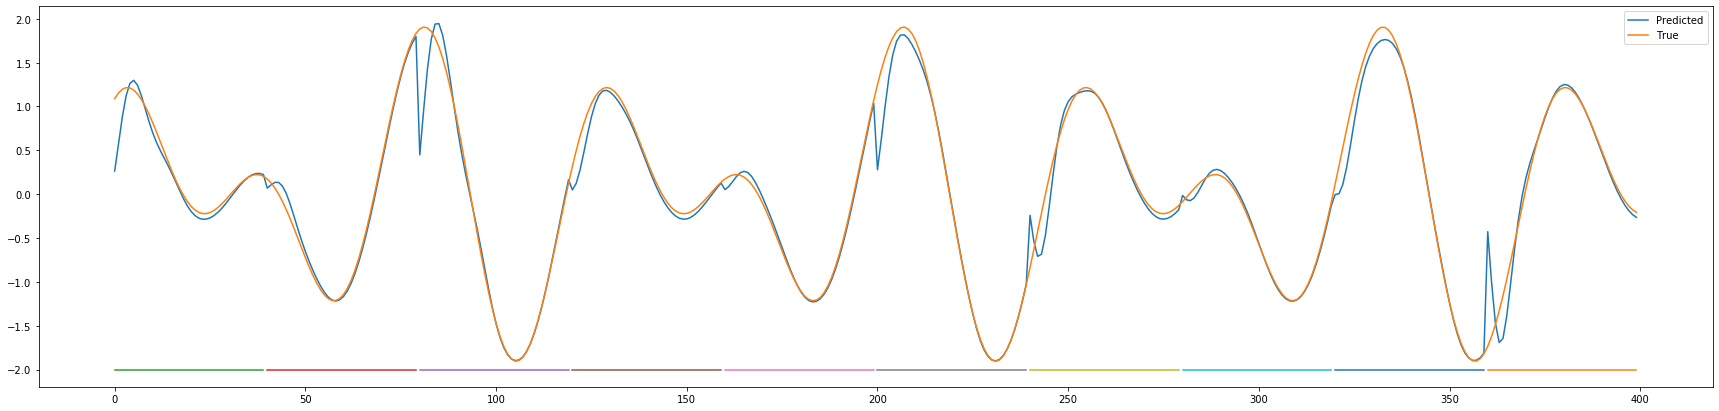

In [13]:
plt.figure(figsize=(30, 7))
plt.plot(pred[:10,:,:].reshape(-1,1,1).squeeze(), label='Predicted')
plt.plot(y_train[:10].reshape(-1,1,1).squeeze(), label='True')
for i in range(10):
    plt.plot(np.arange(i*40, (i+1)*40),np.zeros(40)-2)
plt.legend();

From the plot is clear that the model makes an error every 40 timestep. This is due to sequence splitting.

In fact, by default, the LSMT reset the state after each sequence: at the begginning of each sequence, the predicition error is high because the model does not know anything about the past!

We can overcome this problem using a **stateful** LSTM.

## Stateful LSTM

A stateful LSTM does not reset the internal states of the model after each batch. This allow us to split a sequence along multiple batches without loosing information.


The statefullnes can be introduced setting the parameter **stateful=True**. Also, we **must** know the batch size a compilation time.

In our case, batch_size equals to 1 because we have only one sequence for each batch.

In [9]:
batch_size_st=1
def build_stateful_LSTM_many2many():
    
    model = Sequential()
    model.add(LSTM(30, batch_input_shape=(batch_size_st,seq_len,1), return_sequences=True, stateful=True))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

## Fit the model

In [10]:
LSTM_many2many_st = build_stateful_LSTM_many2many()

LSTM_many2many_st.fit(x_train, y_train, epochs=5, batch_size=batch_size_st);

Epoch 1/5
1249/1249 [==============================] - ETA: 0s - loss: 0.077 - 28s 23ms/step - loss: 0.0775
Epoch 2/5
1249/1249 [==============================] - 28s 23ms/step - loss: 0.0068
Epoch 3/5
1249/1249 [==============================] - 31s 25ms/step - loss: 0.0053
Epoch 4/5
1249/1249 [==============================] - 35s 28ms/step - loss: 0.0045
Epoch 5/5
1249/1249 [==============================] - 33s 26ms/step - loss: 0.0036


# Plot prediction

In [11]:
pred_st = LSTM_many2many_st.predict(x_train, batch_size=batch_size_st)

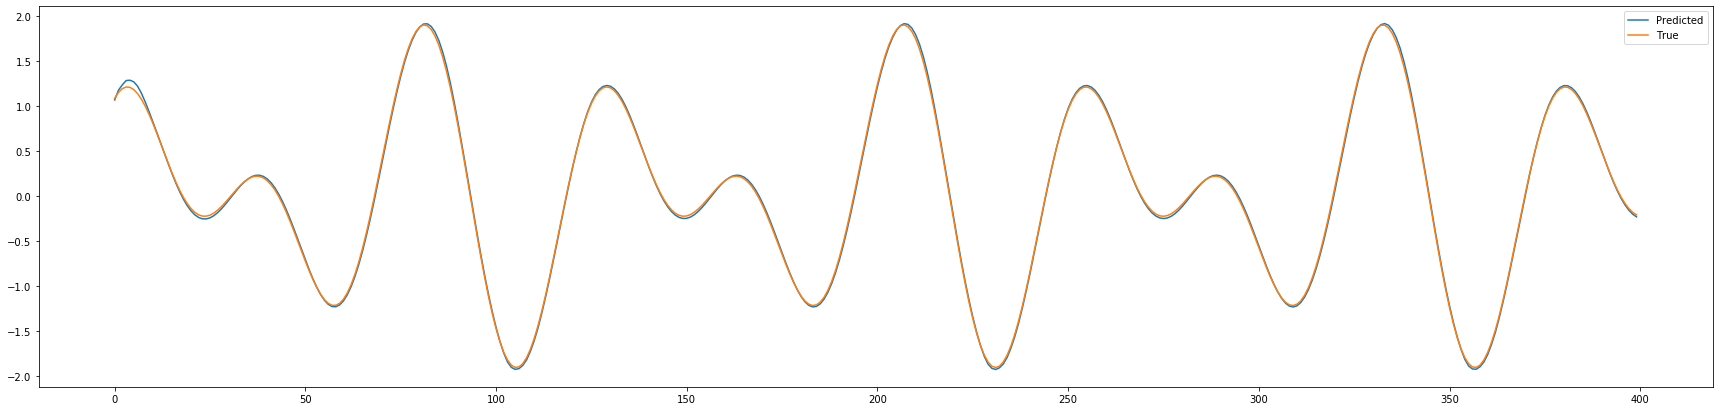

In [12]:
plt.figure(figsize=(30, 7))
plt.plot(pred_st[:10,:,:].reshape(-1,1,1).squeeze(), label='Predicted')
plt.plot(y_train[:10].reshape(-1,1,1).squeeze(), label='True')
plt.legend();